# Aprendizado por Reforço

- Bruno Pilão - 202201037911
- Mateus Norcia - 202201038381
- Isabelle Mamprim - 202109123289


Este trabalho tem como objetivo aplicar os conceitos fundamentais de Aprendizado por Reforço (Reinforcement Learning) através da modelagem de um Processo de Decisão de Markov (MDP), utilizando o ambiente Taxi-v3 disponível na biblioteca Gymnasium.

O ambiente simula um cenário onde um táxi deve buscar um passageiro em um ponto específico e levá-lo até o destino correto, dentro de um grid (5x5) com obstáculos e paredes. O agente (táxi) aprende a agir por tentativa e erro, buscando maximizar a recompensa acumulada com base nas ações tomadas.

![Ambiente Taxi-v3](img/enviroment_taxi.png)



## 🧩 Definição do Markov Decision Process


### Estados (S):
- O ambiente tem 500 estados possíveis. Cada estado representa:
- Posição do táxi (fila, coluna)
- Local de origem do passageiro (uma das 5 localizações fixas)
    - 0: Vermelho
    - 1: Verde
    - 2: Amarelo
    - 3: Azul
    - 4: No taxi

### Ações (A):
- 0 = Mover para sul
- 1 = Mover para norte
- 2 = Mover para leste
- 3 = Mover para oeste
- 4 = Pegar passageiro
- 5 = Deixar passageiro

### Recompensas
- R(s, a) = −1 por passo.
- Estados (0,1);(0,4);(4,1);(3,4) são terminais com recompensa +20 (depedendo da Localização do Hotel).
- Estado tem recompensa negativa −10, por executar indevidamente as ações de embarque e desembarque.
### Transições (P(s'|s,a)):
Determinísticas, exceto quando o táxi tenta atravessar uma parede, nesse caso, ele permanece no mesmo estado.

### Recompensas

- -1 Movimento do Taxi.
- +20 Despachar passageiro corretamente.
- -10 Buscar / Despachar passageiro corretamente.


In [10]:
# Importando pacotes necessarios compilação collab
! pip install gymnasium numpy matplotlib pandas seaborn tqdm pygame -q


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [12]:
# Criando o ambiente Taxi-v3
env_default = gym.make("Taxi-v3")
env_raining = gym.make("Taxi-v3",is_rainy=True)

In [13]:
# Definindo estados do ambiente
estados=[
 (0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
 (1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
 (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
 (3, 0), (3, 1), (3, 2), (3, 3), (3, 4),
 (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)
]

#Definindo ações do ambiente
acoes = {
    0: "South ⬇️",
    1: "North ⬆️",
    2: "East ➡️",
    3: "West ⬅️",
    4: "Pickup 🚖",
    5: "Dropoff 🛑"
}

## Equação de Bellman


In [14]:
# Teste de funcao de Bellman
env_default.action_space.n, env_default.observation_space.n

(np.int64(6), np.int64(500))

In [ ]:
def aplicar_bellman(env, gamma=0.9, theta=1e-6):
    """
    Aplica a Equação de Bellman (Value Iteration) a um ambiente Gym.
    Retorna V(s) e um DataFrame com o histórico de convergência.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    V = np.zeros(n_states)
    history = []
    iter_count = 0

    def bellman_update(V):
        delta = 0
        for s in range(n_states):
            v = V[s]
            values = []
            for a in range(n_actions):
                q_sa = 0
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    q_sa += prob * (reward + gamma * V[next_state] * (not done))
                    # print(f"Estado: {s}, Ação: {a}, Próximo Estado: {next_state}, Recompensa: {reward}, Probabilidade: {prob}, Done: {done}")
                values.append(q_sa)
            V[s] = max(values)
            delta = max(delta, abs(v - V[s]))
        
        return V, delta

    while True:
        V, delta = bellman_update(V)
        iter_count += 1
        history.append({
            "Episodio": iter_count,
            "Valor Médio": np.mean(V),
            "Valor Máximo": np.max(V),
            "Delta": delta,
            "V": V.copy()
            
            
        })
        if delta < theta:
            break

    df = pd.DataFrame(history)
    display(df.head(n=50))
    return df


In [39]:
print("Aplicando Bellman ao ambiente padrão...")    
df_default = aplicar_bellman(env_default)

print("Aplicando Bellman ao ambiente com chuva...")
df_raining = aplicar_bellman(env_raining)

Aplicando Bellman ao ambiente padrão...


,Episodio,Valor Médio,Valor Máximo,Delta,V
0,1,-0.310345,20.0,20.000000,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
1,2,-0.209603,20.0,18.000000,"[17.0, -1.9, -1.9, -1.9, -1.9, -1.9, -1.9, -1...."
2,3,-0.081035,20.0,16.200000,"[17.0, -2.71, -2.71, -2.71, -2.71, -2.71, -2.7..."
3,4,0.293988,20.0,14.580000,"[17.0, -3.439, -3.439, -3.439, -3.439, -3.439,..."
4,5,0.602892,20.0,13.122000,"[17.0, -4.0951, -4.0951, -4.0951, -4.0951, -4...."
5,6,1.252221,20.0,11.809800,"[17.0, -4.68559, 7.714700000000002, -4.68559, ..."
6,7,1.518327,20.0,10.628820,"[17.0, -5.217031, 7.714700000000002, -5.217031..."
7,8,1.874893,20.0,9.565938,"[17.0, 1.6226146700000021, 7.714700000000002, ..."
8,9,2.229907,20.0,8.609344,"[17.0, 1.6226146700000021, 7.714700000000002, ..."
9,10,2.377108,20.0,5.540113,"[17.0, 1.6226146700000021, 7.714700000000002, ..."


Aplicando Bellman ao ambiente com chuva...


,Episodio,Valor Médio,Valor Máximo,Delta,V
0,1,-0.566377,20.0,2.000000e+01,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
1,2,-0.725234,20.0,1.800000e+01,"[17.0, -1.9, -1.9, -1.9, -1.9, -1.9, -1.9, -1...."
2,3,-0.860061,20.0,1.279800e+01,"[17.0, -2.71, -2.71, -2.71, -2.71, -2.71, -2.7..."
3,4,-0.889216,20.0,9.076368e+00,"[17.0, -3.439, -3.439, -3.439, -3.439000000000..."
4,5,-0.830488,20.0,6.404401e+00,"[17.0, -4.0951, -4.0951, -4.0951, -4.0951, -4...."
5,6,-0.680075,20.0,5.067121e+00,"[17.0, -4.68559, 0.39016756160000154, -4.68559..."
6,7,-0.510220,20.0,3.987196e+00,"[17.0, -5.217031, 3.379491895353924, -5.217031..."
7,8,-0.364334,20.0,2.746684e+00,"[17.0, -3.892899809141385, 4.692338830401778, ..."
8,9,-0.241695,20.0,2.279139e+00,"[17.0, -2.3533060414420564, 5.177264277323078,..."
9,10,-0.129182,20.0,2.003453e+00,"[17.0, -1.385144888260025, 5.342820966906371, ..."


## Plots de Visualização


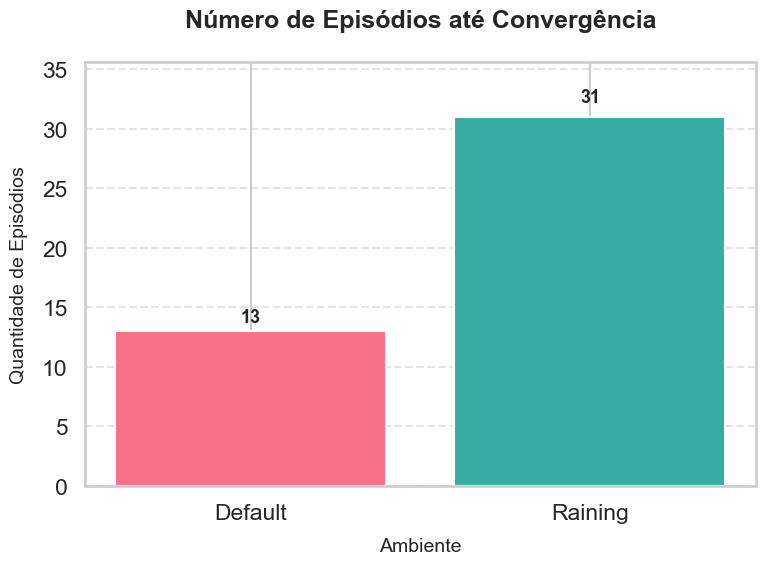

In [87]:
# Configurações visuais consistentes
sns.set_theme(style="whitegrid", context="talk")

# Paleta suave e equilibrada (husl)
palette = sns.color_palette("husl", n_colors=2)

# Criação do gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(
    ["Default", "Raining"],
    [len(df_default), len(df_raining)],
    color=palette
)

# Título e rótulos
plt.title(
    "Número de Episódios até Convergência",
    fontsize=18,
    pad=25,
    weight="bold",
    loc="center"  
)
plt.xlabel("Ambiente", fontsize=14, labelpad=10)
plt.ylabel("Quantidade de Episódios", fontsize=14, labelpad=10)

# Ajuste no espaçamento dos rótulos acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.03 * height),  # pequeno espaçamento vertical
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight="bold",
        
    )

# Grade horizontal discreta
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Margem superior adicional para evitar corte visual
plt.margins(y=0.15)
plt.tight_layout()
plt.show()



In [45]:
def plot_evolucao_V(dataset,title):
    """
    Funcao para plotar a evolução de V(s) ao longo dos episódios
    """

    # Configurações de estilo do seaborn
    sns.set_theme(style="whitegrid", context="talk")

    # Tamanho da figura
    plt.figure(figsize=(22, 10))

    # Paleta clara e equilibrada (husl tem bom contraste)
    palette = sns.color_palette("husl", n_colors=len(dataset))

    # Valor do deslocamento vertical entre episódios
    offset = 3.0  

    # Plotando cada episódio com suavização e deslocamento
    for i in range(len(dataset)):
        v_raw = pd.Series(dataset["V"][i])
        # suaviza um pouco mais
        v_smooth = v_raw.rolling(window=8, center=True, min_periods=1).mean()

        # aplica deslocamento vertical para separar visualmente as curvas
        v_data = pd.DataFrame({
            "Estado": range(len(v_smooth)),
            "Valor": v_smooth + (i * offset)
        })

        sns.lineplot(
            data=v_data,
            x="Estado",
            y="Valor",
            color=palette[i],
            linewidth=2.0,
            alpha=0.75,
            label=f"Episódio {i+1}"
        )


    # Customizações 
    plt.title(f"Evolução de V(s) — Ambiente {title} ", fontsize=22, pad=25, weight="bold")
    plt.xlabel("Estado (s)", fontsize=16)
    plt.ylabel("Valor de V(s) (com deslocamento visual)", fontsize=16)

    # Legenda lateral organizada
    plt.legend(
        title="Episódios",
        bbox_to_anchor=(1,1),
        loc='upper left',
        fontsize=12,
        frameon=True,
        framealpha=0.9
    )

    # Grade e espaçamento
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.margins(y=0.1)
    plt.tight_layout()
    plt.show()
    
    # Printando valor medio por episodio
    for i in range(len(dataset)):
        print(f"Episódio {i+1}: Valor médio de V(s) = {dataset['Valor Médio'][i]:.4f}")


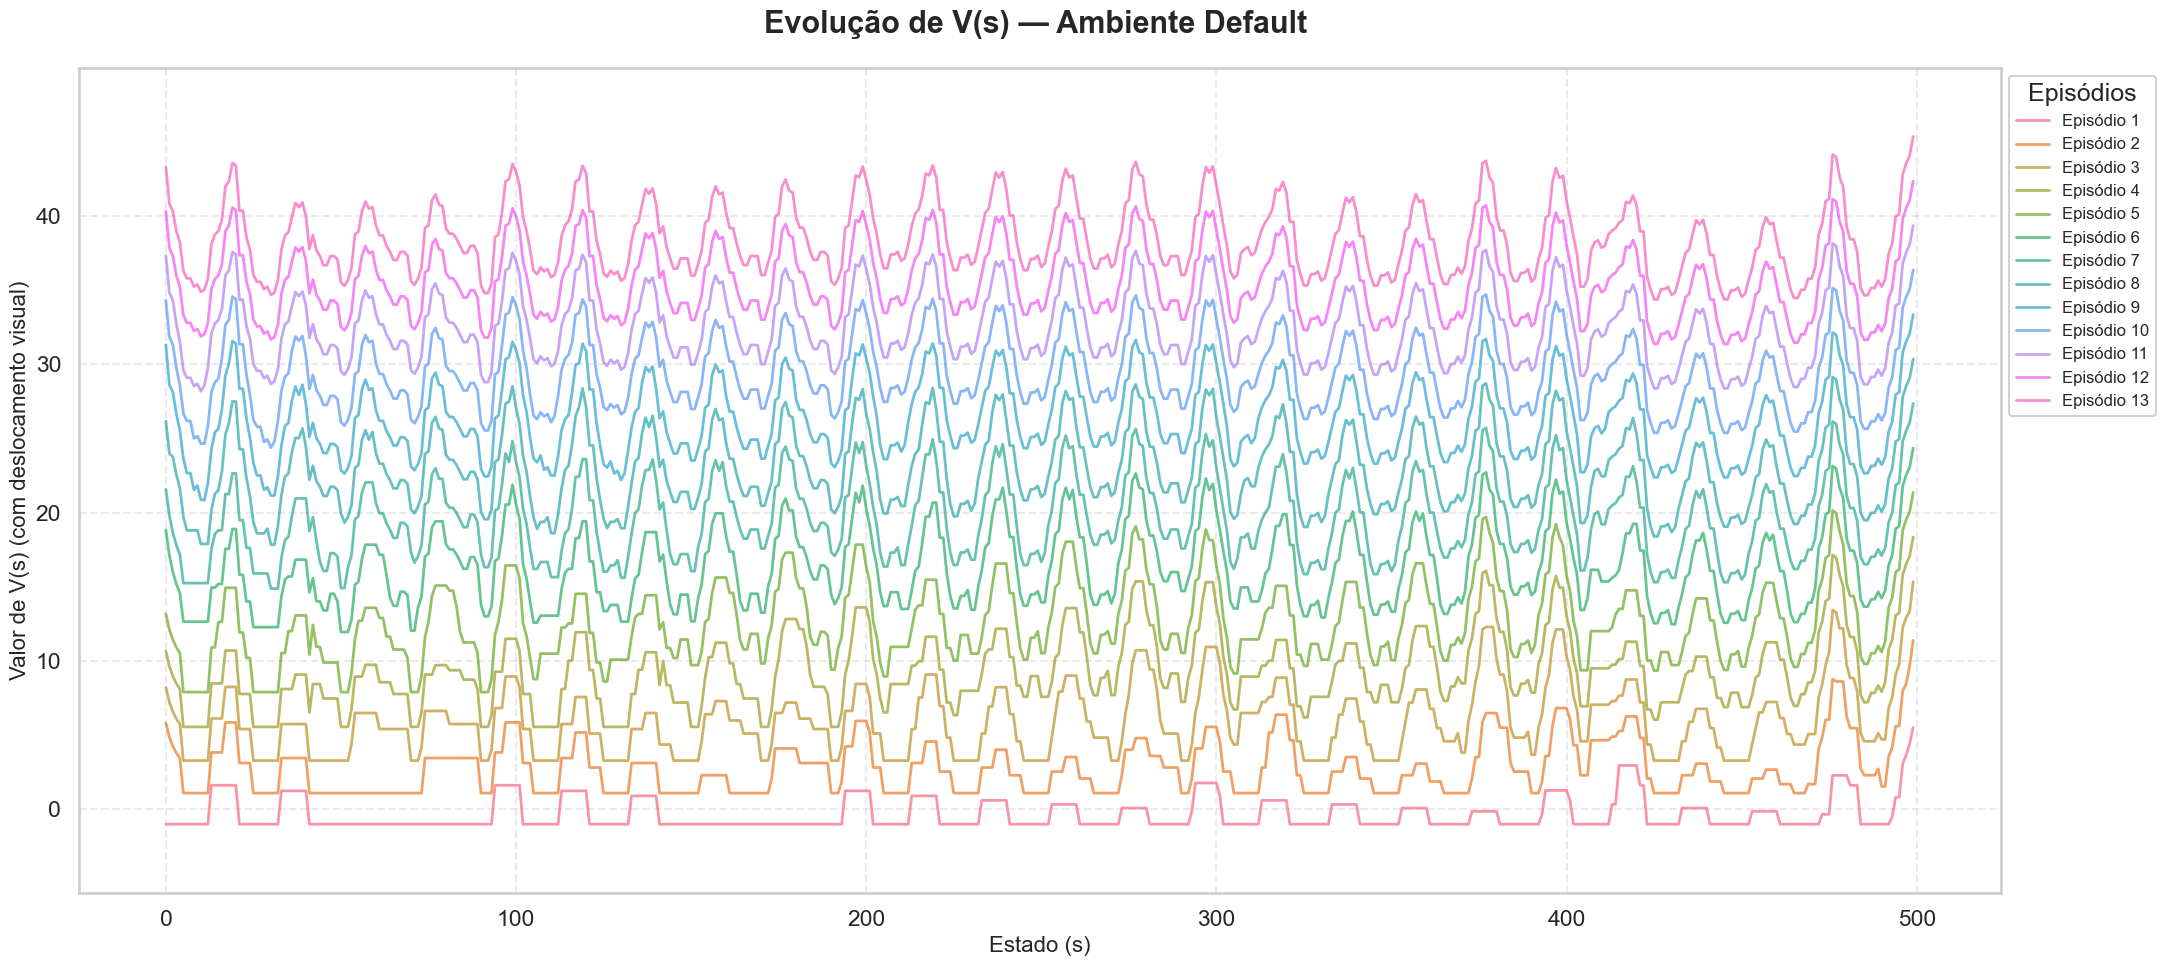

Episódio 1: Valor médio de V(s) = -0.3103
Episódio 2: Valor médio de V(s) = -0.2096
Episódio 3: Valor médio de V(s) = -0.0810
Episódio 4: Valor médio de V(s) = 0.2940
Episódio 5: Valor médio de V(s) = 0.6029
Episódio 6: Valor médio de V(s) = 1.2522
Episódio 7: Valor médio de V(s) = 1.5183
Episódio 8: Valor médio de V(s) = 1.8749
Episódio 9: Valor médio de V(s) = 2.2299
Episódio 10: Valor médio de V(s) = 2.3771
Episódio 11: Valor médio de V(s) = 2.4567
Episódio 12: Valor médio de V(s) = 2.4679
Episódio 13: Valor médio de V(s) = 2.4679


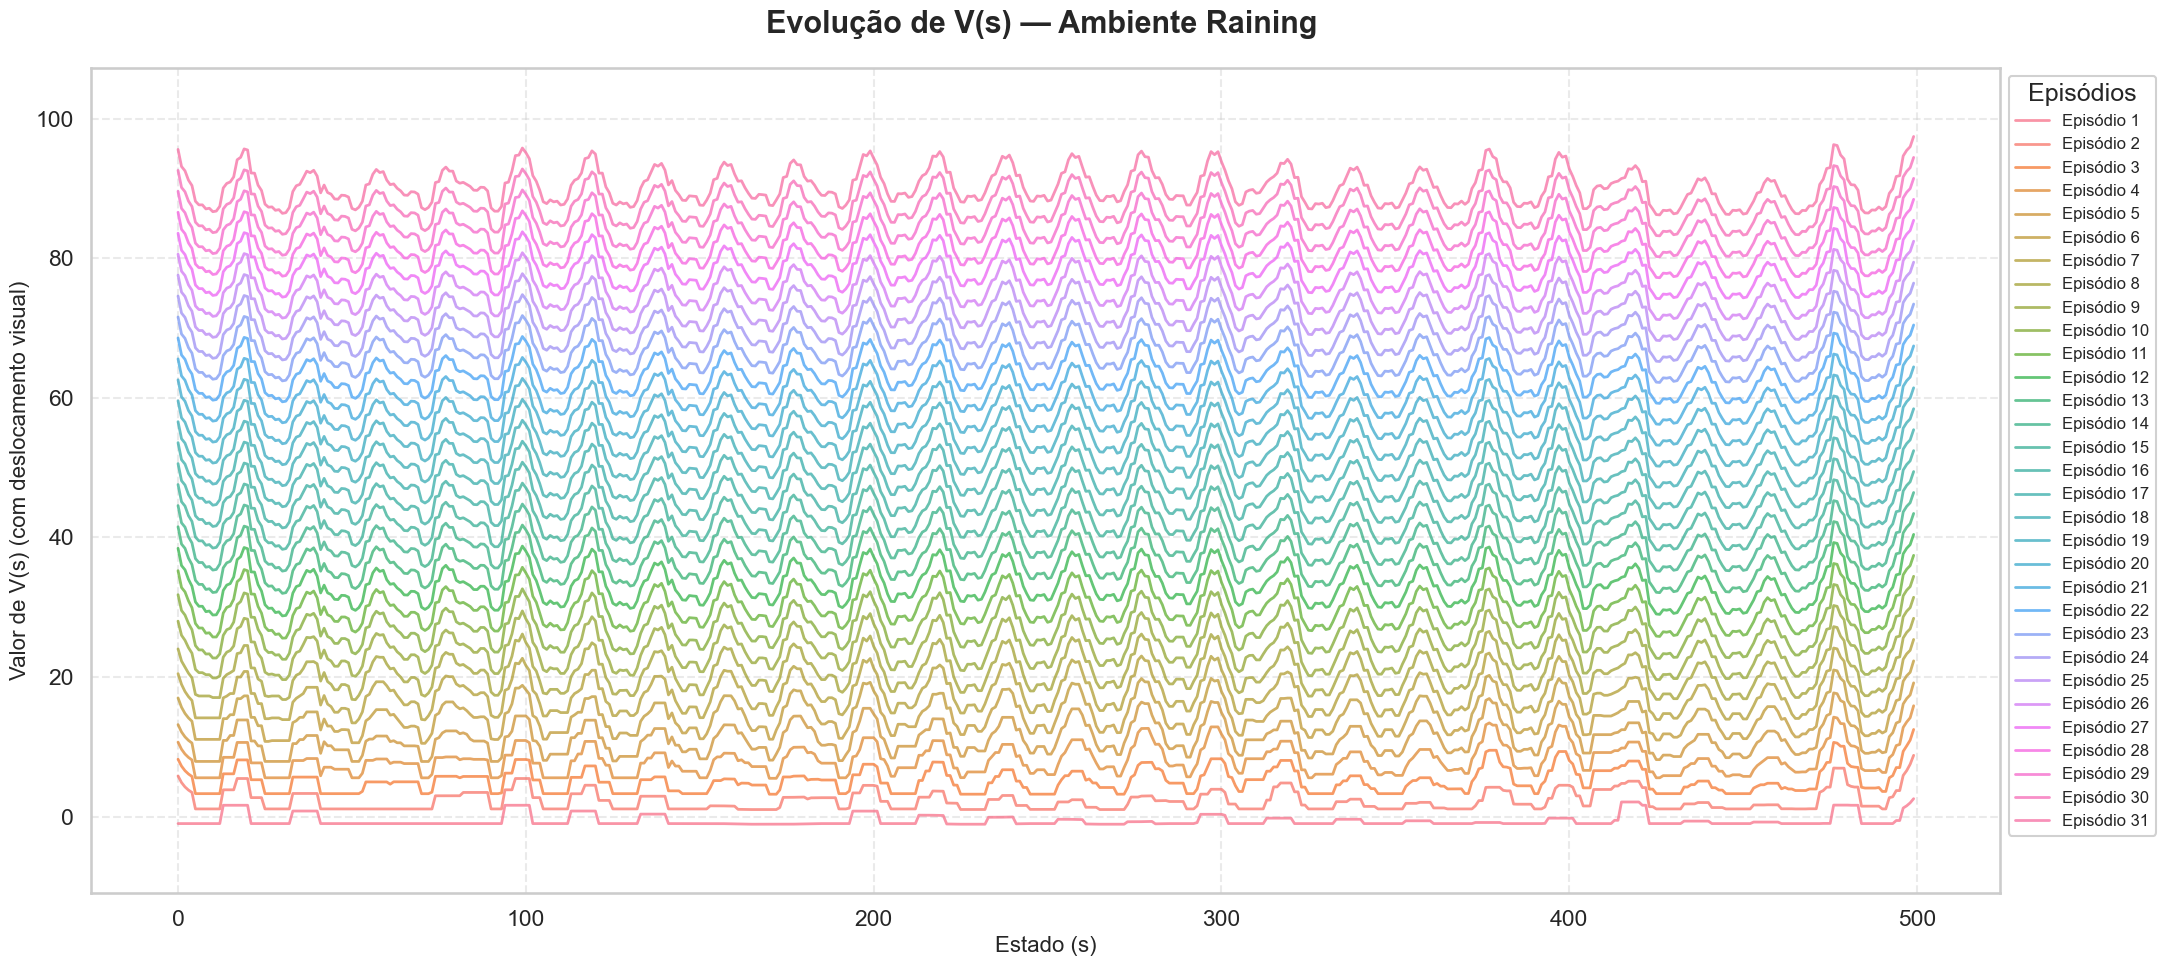

Episódio 1: Valor médio de V(s) = -0.5664
Episódio 2: Valor médio de V(s) = -0.7252
Episódio 3: Valor médio de V(s) = -0.8601
Episódio 4: Valor médio de V(s) = -0.8892
Episódio 5: Valor médio de V(s) = -0.8305
Episódio 6: Valor médio de V(s) = -0.6801
Episódio 7: Valor médio de V(s) = -0.5102
Episódio 8: Valor médio de V(s) = -0.3643
Episódio 9: Valor médio de V(s) = -0.2417
Episódio 10: Valor médio de V(s) = -0.1292
Episódio 11: Valor médio de V(s) = -0.0215
Episódio 12: Valor médio de V(s) = 0.0753
Episódio 13: Valor médio de V(s) = 0.1501
Episódio 14: Valor médio de V(s) = 0.1994
Episódio 15: Valor médio de V(s) = 0.2280
Episódio 16: Valor médio de V(s) = 0.2431
Episódio 17: Valor médio de V(s) = 0.2506
Episódio 18: Valor médio de V(s) = 0.2540
Episódio 19: Valor médio de V(s) = 0.2556
Episódio 20: Valor médio de V(s) = 0.2562
Episódio 21: Valor médio de V(s) = 0.2565
Episódio 22: Valor médio de V(s) = 0.2566
Episódio 23: Valor médio de V(s) = 0.2567
Episódio 24: Valor médio de V(s)

In [46]:
# Plotando a evolução de V(s) para o ambiente padrão
plot_evolucao_V(df_default,"Default")

# Plotando a evolução de V(s) para o ambiente com chuva
plot_evolucao_V(df_raining,"Raining")